In [246]:
from pprint import pformat
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

In [247]:
from pathlib import Path
import random

In [248]:
def read_list(file_path='../data/soundAttGAN/koreancorpus.xlsx', data_path='../data/soundAttGAN', hub=None):
    
    file_list = []
    
    if hub:
        logging.info(f'reading hub data from {hub}')
        p = Path(hub)
        for each in p.iterdir():
            for wav in each.glob('*.wav'):
                file_list.append({
                    "fileName": str(wav)
                })
        

    else:
        logging.info(f'reading lab data from {data_path} & {file_path}')

        info_file = pd.read_excel(file_path, sheet_name="Sheet1")

        def _append_to_file_list(row, file_list):
            """data_path 읽어서 file_list 에 넣음,

            :param row: 엑셀
            :param file_list:
            :return: None
            """
            file_name = f"{data_path}/{int(row['fileName'])}_{int(row['suffix'])}.wav"

            text = row["text"]

            file_list.append({
                    "fileName": file_name,
                    "text": text
            })

        info_file.apply(partial(_append_to_file_list, file_list=file_list), axis=1)

    return file_list

In [546]:
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import MinMaxScaler
# from env import *

import logging

logger = logging.getLogger()
logger.setLevel("DEBUG")

def load_config(file):
    with open(file) as f:
        data = json.load(f)
    return data


class DataLoader():

    def __init__(self, config='./config.json'):
        logging.info(f'DataLoader initializing')
        logging.info(f'configuration setting from {config}')        
        self.config = load_config(config)
        logging.info(pformat(self.config))
        
        self.data_lab = None    
        self.data_hub = None    
        
        self.sr = self.config['sr_hub']
        self.hop_length = self.config['hop_length']
        self.n_fft = self.config['n_fft']
        

        
        self.build()
        
#         logging.info(f'frame rate: {}')


    def build(self):
        self.data_lab = read_list()
        self.data_hub = read_list(hub=self.config['data_hub'])
        

    def train_generator(self, data, norm=True):
        """audio Generator

        :return: y, sr
        """
        if data == 'lab':
            files = self.data_lab
            raise NotImplementedError
        elif data == 'hub':
            print("@@")
            files = self.data_hub
        else:
            raise TypeError

        for each in files:
            file_name = each['fileName']
            _y, _sr = librosa.load(file_name, sr=self.sr)
            
            if norm:
                div = max(_y.max(), abs(_y.min()))
                _y = _y * (1. / div)
                
            _y = self._melspectrogram(_y)

#             if stft:
#                 # D:np.ndarray [shape=(1 + n_fft/2, t), dtype=dtype]
#                 _y = self.stft(_y)
#                 _y = np.expand_dims(_y, axis=-1)

            yield _y

#     def stft(self, y, db=False, abs=False):
#         """short time fourier transform"""
        
#         # [shape=(1 + n_fft/2, t), dtype=dtype]
#         y = librosa.stft(y=y, 
#                          n_fft=self.config['n_fft'], 
#                          window=self.config['window'],
#                          hop_length=self.config['hop_length'],
#                         dtype=np.float32)
#         print(y)
#         if abs:
#             y = np.abs(y)

#         if db:
#             y = librosa.amplitude_to_db(y, ref=np.max)

#         return y
    
    def _melspectrogram(self, y):
        """Compute a mel-scaled spectrogram"""
        # [shape=(n_mels, t)]
        return librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.config['n_mels'], n_fft=self.config['n_fft'], S=None, hop_length=self.config['hop_length'], win_length=None,
                                             window=self.config['window'], center=True, pad_mode='reflect', power=2.0)
    
    def _mel_to_audio(self, mel):
        return librosa.feature.inverse.mel_to_audio(mel, sr=self.config['sr_hub'], n_fft=self.config['n_fft'], hop_length=self.config['hop_length'])
    
#     def istft(self, stft_matrix):
#         return librosa.istft(stft_matrix=stft_matrix, hop_length=self.config['hop_length'])
    
    def _power_to_db(self, s):
        return librosa.power_to_db(s, ref=np.max)

    def specshow(self, y, mel=True):
        """plot spectrogram

        :param y:
        :return: axis
        """
        if mel:
            y = self._power_to_db(y)
            librosa.display.specshow(y, y_axis='mel', x_axis='time')
            plt.title('Mel spectrogram')
        else:
#             y = librosa.amplitude_to_db(y, ref=np.max)
            raise NotImplementedError
            librosa.display.specshow(y, hop_length=self.config['hop_length'],
                                y_axis='log', x_axis='time')
            plt.title('Power spectrogram')

        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
        
    def random_audio(self, path=None, mel_to_audio=False, specshow=True):

        if path:
            raise NotImplementedError
            y, sr = librosa.load(path)
        
        else:
            y, sr = librosa.load(random.choice(self.data_hub)['fileName'], sr=self.config['sr_hub'])
            
        if mel_to_audio:
            y = self._melspectrogram(y)
            self.specshow(y, mel=True)
            y = self._mel_to_audio(y)
        else:
#             self.specshow(y, mel=False)
            pass
            
        return y, sr
    
    def test_train_generator(self):
        """
        
        :return: audio
        """
        it = iter(self.train_generator(data='hub'))
        import random
        r_number = random.randint(0, 100)
        for _ in range(r_number):
            _y = next(it)
        return self._mel_to_audio(_y)

dl = DataLoader()

INFO:root:DataLoader initializing
INFO:root:configuration setting from ./config.json
INFO:root:{'data_hub': '../data/KsponSpeech_01',
 'data_lab': '../data/soundAttGAN',
 'data_lab_xlsx': '../data/soundAttGAN/koreancorpus.xlsx',
 'hop_length': 128,
 'n_fft': 512,
 'n_mels': 128,
 'sr_hub': 16000,
 'sr_lab': 22050,
 'window': 'hann'}
INFO:root:reading lab data from ../data/soundAttGAN & ../data/soundAttGAN/koreancorpus.xlsx
INFO:root:reading hub data from ../data/KsponSpeech_01


In [483]:
y, sr = dl.random_audio(mel_to_audio=False)
IPython.display.Audio(y, rate=sr)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f29657d9b90>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f29657d9b90>
DEBUG:matplotlib.colorbar:Setting pcolormesh


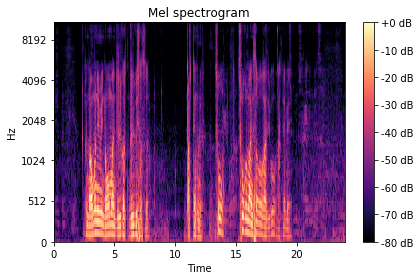

In [544]:
y, sr = dl.random_audio(mel_to_audio=True)
IPython.display.Audio(y, rate=sr)

In [462]:
mel = dl._melspectrogram(y, sr)
mel.shape
# print(mel)

(128, 929)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f296518c210>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f296518c210>
DEBUG:matplotlib.colorbar:Setting pcolormesh


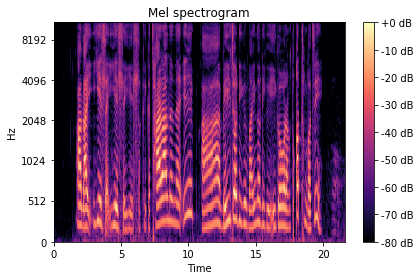

In [543]:
dl.specshow(mel, mel=True)